# Data

In [7]:
dat = read.table("cookies.txt", header = TRUE)
head(dat)

chips,location
12,1
12,1
6,1
13,1
12,1
12,1


In [9]:
unique(dat$location)

[1] 1 2 3 4 5

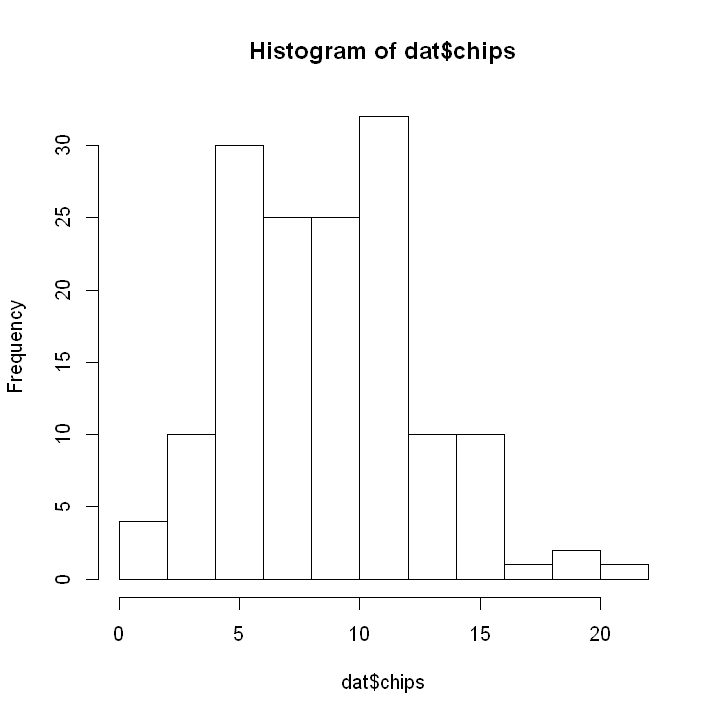

In [19]:
options(repr.plot.width=6, repr.plot.height=6)

hist(dat$chips)

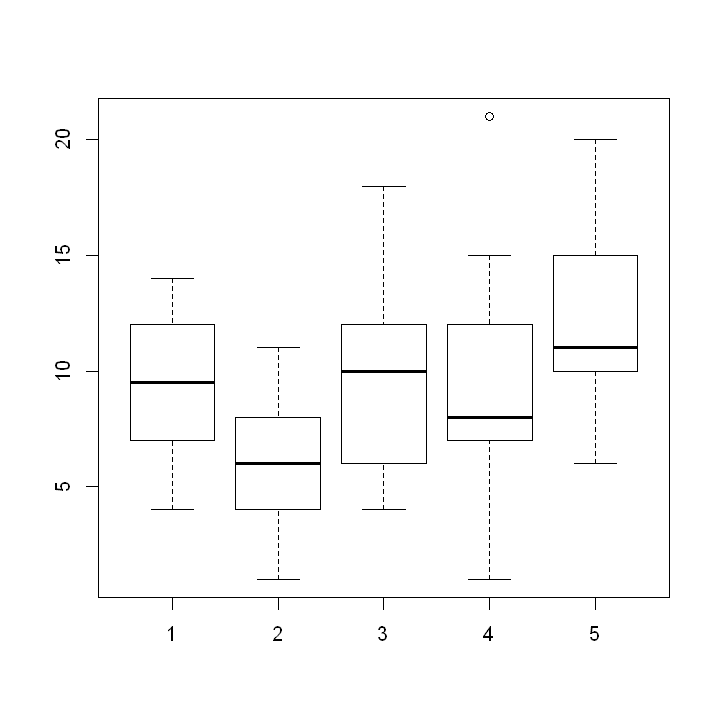

In [20]:
boxplot(chips ~ location, data = dat)

# Prior Predictive Check


Before implementing the model, we need to select prior distributions for α and β, the hyperparameters governing the gamma distribution for the λ parameters. First, think about what the λ’s represent. For location j, λj is the expected number of chocolate chips per cookie. Hence, α and β control the distribution of these means between locations. The mean of this gamma distribution will represent the overall mean of number of chips for all cookies. The variance of this gamma distribution controls the variability between locations. If this is high, the mean number of chips will vary widely from location to location. If it is small, the mean number of chips will be nearly the same from location to location.

To see the effects of different priors on the distribution of λ’s, we can simulate. Suppose we try independent exponential priors for α and β.

<img src="hierarchy.PNG"/>

In [76]:
set.seed(112)

In [77]:
n_sim = 1e3

alpha_prior = rexp(n_sim, rate = 1.0/2.0)
beta_prior = rexp(n_sim, rate = 5.0)

mu_prior = (alpha_prior ^ 2) / (beta_prior ^ 2)
sig_prior = sqrt( alpha_prior/ (beta_prior ^ 2) )

In [78]:
summary(mu_prior)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
       0       11       93    47997      713 37405797 

In [79]:
summary(sig_prior)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   0.169    3.702    8.194   29.394   19.331 4660.062 

In [80]:
# After simulating from the priors for α and β, we can use those samples to simulate further down the hierarchy.

lambda_prior = rgamma(n = n_sim, 
                      shape = alpha_prior, 
                      rate = beta_prior)

summary(lambda_prior)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   0.000    1.073    6.838   40.477   25.373 5211.686 

In [81]:
# Or for a prior predictive reconstruction of the original data set:

lambda_prior = rgamma(n = 5, 
                      shape = alpha_prior, 
                      rate = beta_prior)

summary(lambda_prior)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.767   4.737  11.836  16.499  17.928  46.226 

In [82]:
y_prior = rpois(n = 150, lambda = rep(lambda_prior, each=30))

y_prior

[1]  7  4  4  3  9  7  1  2  4  3  5  4  3  5  5  3  7  6  4  5  2  3  6  7  8
 [26]  6  8  3  3  3 20 14 16 15 18 26 14 20 16 18 17 19 28 18 11 20 10 17 22 17
 [51] 14 22 17 25 23 21 18 13 11 20 12 13 13 15 11 14  9  9 11  9 11 15  7  9  8
 [76]  9 12 16 12 22 10 11 14 17 10  6  9 17 11 10  3  2  1  4  0  2  2  0  1  0
[101]  2  1  1  0  1  0  0  4  0  1  2  1  4  2  1  0  2  0  5  3 43 42 47 39 52
[126] 50 53 50 49 54 44 42 40 53 51 31 47 44 61 53 56 40 41 49 48 54 49 52 48 43

Because these priors have high variance and are somewhat noninformative, they produce unrealistic predictive distributions. Still, enough data would overwhelm the prior, resulting in useful posterior distributions. Alternatively, we could tweak and simulate from these prior distributions until they adequately represent our prior beliefs. Yet another approach would be to re-parameterize the gamma prior, which we’ll demonstrate as we fit the model.

# JAGS Model

In [86]:
library("coda")
library("rjags")

In [87]:
head(dat)

chips,location
12,1
12,1
6,1
13,1
12,1
12,1


<img src="hierarchy.PNG"/>

In [108]:
mod_str = " model {
    # Model's Likelihood Hierarchy
    for(i in 1:length(chips)){
        chips[i] ~ dpois(lam[location[i]])
    }

    for(j in 1:max(location)){
        lam[j] ~ dgamma(alpha, beta)
    }
    
    # Priors (in form of mu and sig)

    alpha = mu^2 / sig^2
    beta = mu / sig^2

    mu ~ dgamma(2.0, 1.0/5.0)
    sig ~ dexp(1.0)
} "

In [109]:
set.seed(113)

In [110]:
data_jags = as.list(dat)

In [111]:
params = c("lam", "mu", "sig")

In [112]:
mod = jags.model(textConnection(mod_str), 
                 data = data_jags, 
                 n.chains = 3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 150
   Unobserved stochastic nodes: 7
   Total graph size: 315

Initializing model



In [113]:
update(mod, 1e3)

mod_sim = coda.samples(model = mod, 
                       variable.names = params, 
                       n.iter = 1e4)

mod_csim = as.mcmc(do.call(rbind, mod_sim))

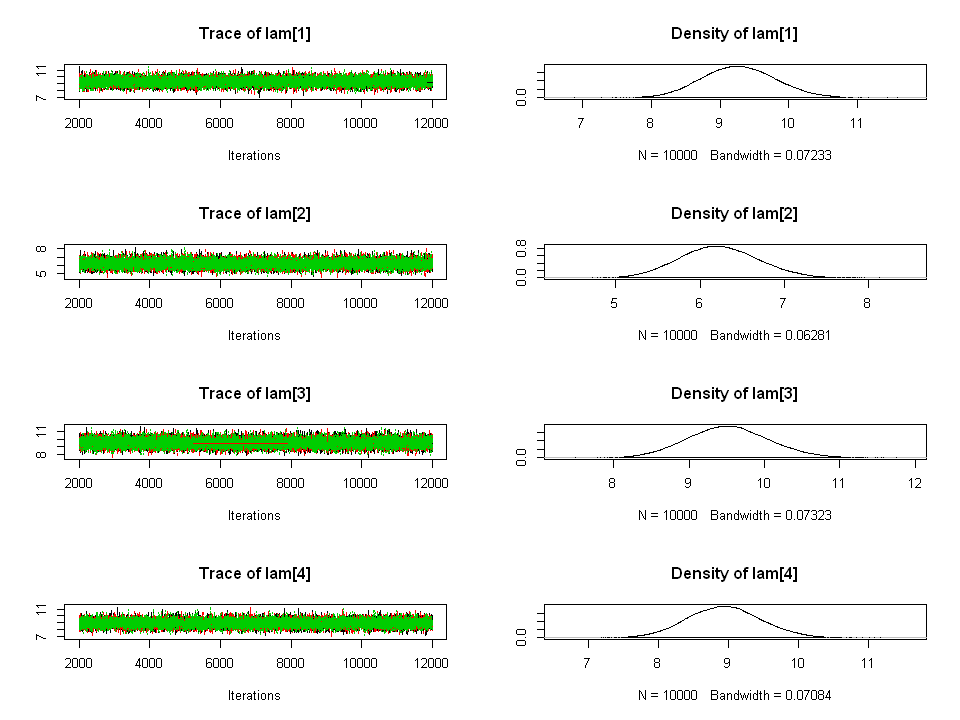

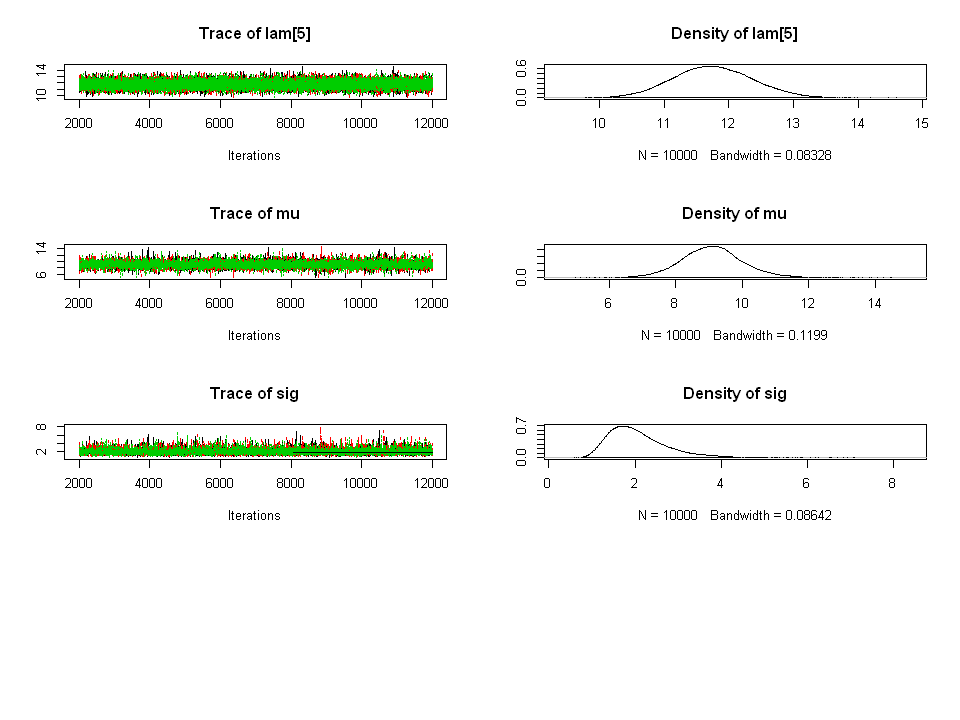

In [117]:
# Convergence Dignosis

options(repr.plot.width = 8, repr.model.height=10)

plot(mod_sim)

In [118]:
# Convergence Dignosis

gelman.diag(mod_sim)
autocorr.diag(mod_sim)
effectiveSize(mod_sim)

Potential scale reduction factors:

       Point est. Upper C.I.
lam[1]          1       1.00
lam[2]          1       1.00
lam[3]          1       1.00
lam[4]          1       1.00
lam[5]          1       1.00
mu              1       1.00
sig             1       1.01

Multivariate psrf

1

,lam[1],lam[2],lam[3],lam[4],lam[5],mu,sig
Lag 0,1.000000000,1.000000000,1.000000000,1.000000000,1.0000000000,1.000000000,1.000000000
Lag 1,0.021463502,0.114595593,0.020696649,0.017618005,0.0527976236,0.362838787,0.577377754
Lag 5,-0.002011615,0.011392753,0.011267827,0.004017828,-0.0021057278,0.036607874,0.112014090
Lag 10,0.006004817,-0.007817243,0.007520775,-0.005142256,0.0045224113,0.004380728,0.028832049
Lag 50,0.001455334,0.002218589,0.001504790,-0.003138118,0.0003491664,-0.003710645,-0.003494343


lam[1]    lam[2]    lam[3]    lam[4]    lam[5]        mu       sig 
28969.536 21580.716 28566.687 28846.927 25821.711 12147.292  7006.371

In [119]:
# Compute Dic

dic = dic.samples(model = mod, n.iter = 1e4)
dic

Mean deviance:  783.7 
penalty 4.826 
Penalized deviance: 788.5 

In [120]:
colMeans(mod_csim)

lam[1]    lam[2]    lam[3]    lam[4]    lam[5]        mu       sig 
 9.279270  6.226985  9.524270  8.943150 11.755931  9.105214  2.086358

# Model checking

After assessing convergence, we can check the fit via residuals. With a hierarchical model, there are now two levels of residuals: the observation level and the location mean level. To simplify, we’ll look at the residuals associated with the posterior means of the parameters.

In [121]:
# First, we have observation residuals, based on the estimates of location means.
# Observation level Residuals

pm_params = colMeans(mod_csim)

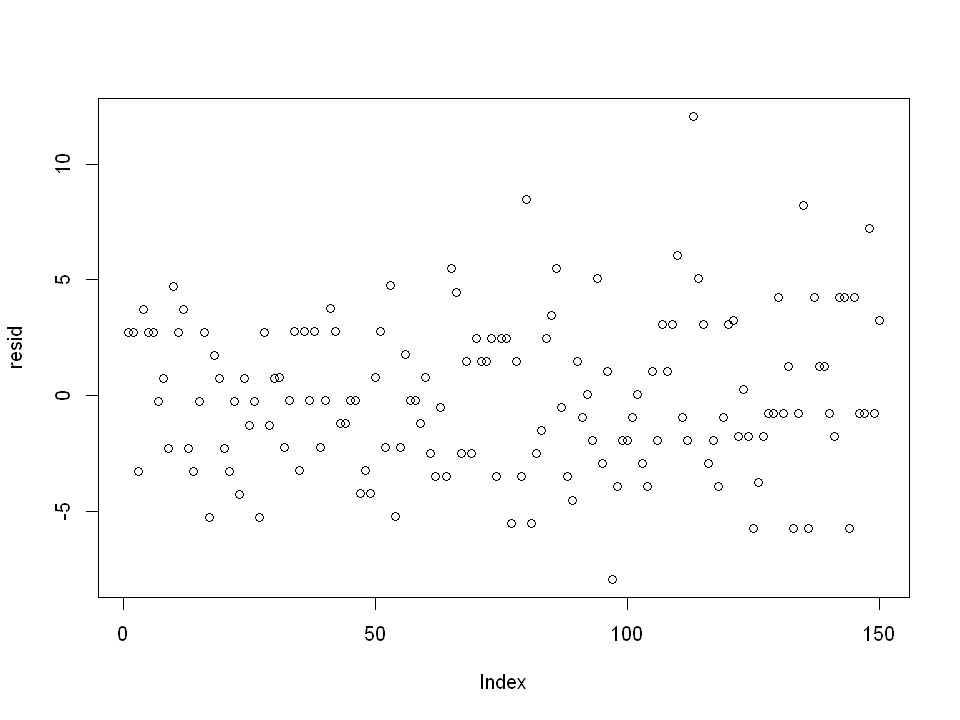

In [126]:
yhat = rep(pm_params[1:5], each = 30)
resid = dat$chips - yhat

options(repr.plot.width = 8, repr.plot.height=6)
plot(resid)

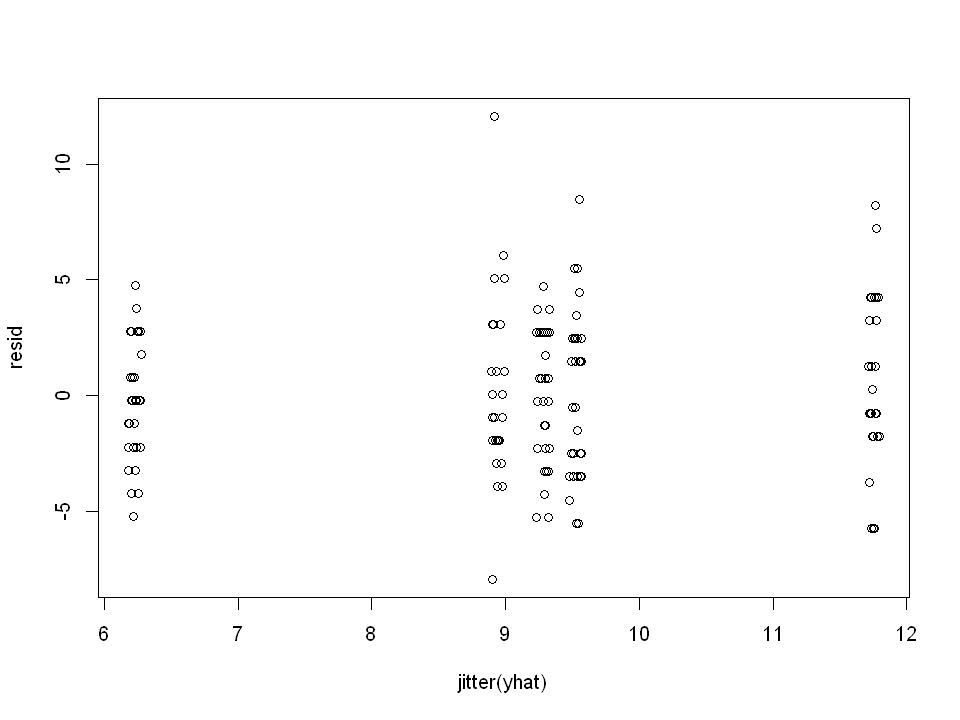

In [129]:
plot(jitter(yhat), resid)

# We can observe here that that variance has incresed as yhat increases like our hypothesis ie. Poisson.

If out hypothesis is not violated then mean will be equal to variance.

In [130]:
var(resid[yhat<7])

[1] 6.447126

In [131]:
var(resid[yhat>11])

[1] 13.72414

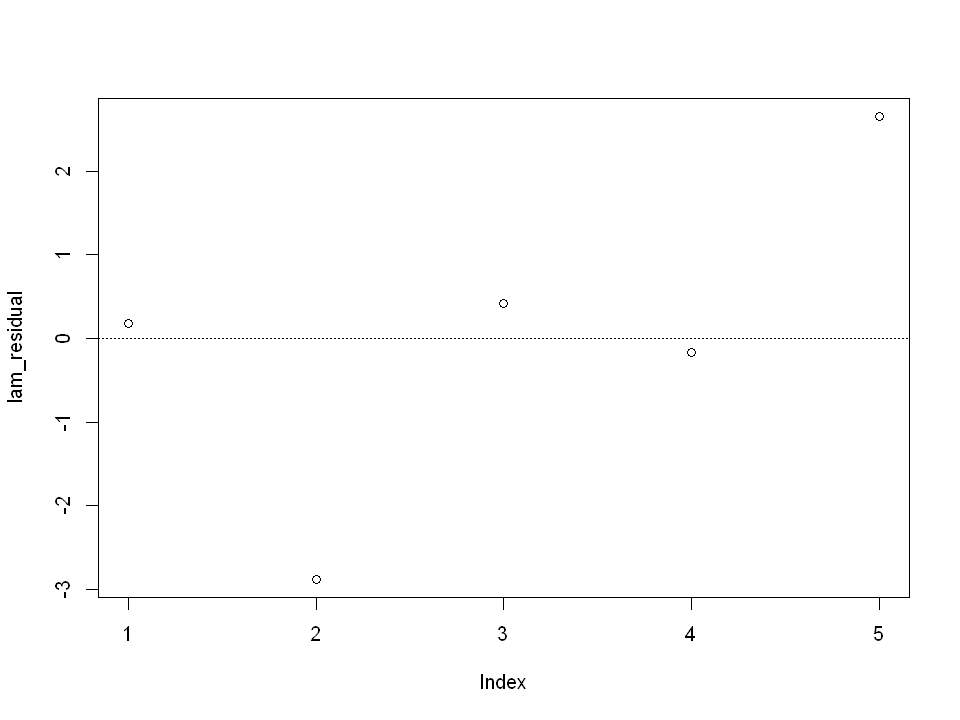

In [133]:
# Location level Residuals

lam_residual = pm_params[1:5] - pm_params["mu"]
plot(lam_residual)
abline(h=0, lty=3)

# We don’t see any obvious violations of our model assumptions.

# Results

In [135]:
summary(mod_sim)


Iterations = 2001:12000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

         Mean     SD Naive SE Time-series SE
lam[1]  9.279 0.5363 0.003096       0.003153
lam[2]  6.227 0.4658 0.002689       0.003171
lam[3]  9.524 0.5433 0.003137       0.003219
lam[4]  8.943 0.5253 0.003033       0.003094
lam[5] 11.756 0.6175 0.003565       0.003843
mu      9.105 0.9792 0.005653       0.008885
sig     2.086 0.7211 0.004163       0.008649

2. Quantiles for each variable:

         2.5%    25%    50%    75%  97.5%
lam[1]  8.260  8.912  9.269  9.636 10.364
lam[2]  5.344  5.905  6.216  6.535  7.161
lam[3]  8.488  9.155  9.516  9.882 10.632
lam[4]  7.935  8.583  8.936  9.288  9.990
lam[5] 10.569 11.333 11.743 12.169 12.994
mu      7.232  8.485  9.087  9.676 11.157
sig     1.094  1.579  1.948  2.437  3.887
